# AEMO Renewables and Emissions
By Michael Hallam.

# Abstract

In this notebook, we take a brief look at energy data provided by the Australian Energy Market Operator (AEMO) over a 24-hour period on 2024/11/01. We focus on the spread of fuel sources in regions participating in the National Electricity Market (NEM), the prevalence of renewables, and the greenhouse gas emissions over this period, producing the following plots:

| | | 
|:-------------------------:|:-------------------------:|
|<img height="300" src="images/renewable-percentage.png"> |  <img height="300" src="images/energy-generation-time.png">|
|<img height="300" src="images/energy-generation-total.png">  |  <img height="300" src="images/carbon-emissions.png">|

We find the total percentage of energy generated by renewables over the 24-hour period is 46.4%. Renewable energy generation reaches a peak of 72.5% during daylight hours when solar generation is at its peak, and attains a minimum of 22.5% before sunrise. The total carbon emissions over the 24-hour period are approximately 298,000 t CO2-e, with a minimum emissions rate during daylight hours of 7,350 t CO2-e / h, and a maximum emissions rate of 16,351 t CO2-e / h early in the evening.

## 1. Introduction

In Australia, the wholesale of electricity on the National Electricity Market (NEM) is governed by the Australian Energy Market Operator (AEMO). Participants of the NEM buy and sell electricity in South Australia, Tasmania, Victoria, New South Wales, and Queensland, at prices determined via a centralised bidding system overseen by AEMO. Stability of the electricity grid is also maintained by AEMO, through systems such as Frequency Control Ancillary Service (FCAS), which ensure that the supply and demand of electricity within the grid are matched at all times.

AEMO also collects data on electricity generation, loads, and transfer between NEM participant regions. In this notebook, we take a brief look at publicly available data provided by AEMO over a fixed 24-hour period (from 2024/11/01 00:00 until 2024/11/02 00:00), with the aim of examining some of the main sources of Australia's electricity, the share of renewable energy generation in Australia, and the CO2-e emissions produced by NEM participant regions.

We use the Python package [NEMOSIS](https://github.com/UNSW-CEEM/NEMOSIS) to conveniently collect data provided by AEMO from [nemweb](http://nemweb.com.au/Reports/Current/). Certain data will be inaccessible through NEMOSIS, which we will instead download directly from AEMO's [data archive](https://visualisations.aemo.com.au/aemo/nemweb/index.html#mms-data-model).

### Outline and Findings
- In Section 2 we import dispatch unit data from AEMO, do some minor data cleaning and preparation for analysis in later sections, and plot a few graphs giving a breakdown of generator types.
- In Section 3 we take a look at electricity generation data in NEM regions on 2024/11/01, and break down the production of energy by fuel source. We observe a large rise in renewable generation during daylight hours due to solar generation, which drops overnight. Peak renewable generation is approximately 72.5% during daylight hours, and minimum renewable generation is roughly 22.5% before sunrise. The total percentage of renewable energy generation over the 24-hour period is around 46.4%.
- In Section 4 we examine the CO2-e emissions in NEM participant regions on 2024/11/01. Total emissions over the 24-hour period are approximately 298,000 tonnes of CO2-e. Emissions decrease during daylight hours due to solar generation, but rise overnight when there is a greater reliance on fossil fuels. Peak emissions occur at around 19:00, reaching a maximum rate of 16,351 t CO2-e / h. Minimum emissions occur around midday, at a rate of 7,350 t CO2-e / h.
- In Section 5, we summarise our findings.

### Useful Resources
- The [NEMOSIS Wiki](https://github.com/UNSW-CEEM/NEMOSIS/wiki) contains a list of tables and brief descriptions of columns available through the [NEMOSIS Package](https://github.com/UNSW-CEEM/NEMOSIS), used in this notebook. Note some information in the wiki is outdated, for example there are now 10 FCAS markets rather than 8.
- AEMO's [NEM Dashboard](https://aemo.com.au/Energy-systems/Electricity/National-Electricity-Market-NEM/Data-NEM/Data-Dashboard-NEM) has useful summary information on energy generation and transfer between NEM participant regions, and more.
- AEMO's [Dispatch Procedure](https://aemo.com.au/-/media/files/electricity/nem/security_and_reliability/power_system_ops/procedures/so_op_3705-dispatch.pdf?la=en) gives general information about the NEM dispatch process.
- AEMO's [Guide to Generator Exemptions and Classification of Generating Units](https://wa.aemo.com.au/-/media/Files/Electricity/NEM/Participant_Information/New-Participants/Generator-Exemption-and-Classification-Guide.pdf) gives general information on dispatch units operating within the NEM.
- AEMO's [Electricity Data Model Report](https://visualisations.aemo.com.au/aemo/di-help/Content/Data_Model/Electricity_Data_Model_Report_54.pdf) is a reference manual for the AEMO's NEM database; it has a full list of all tables available and their columns, but is light on details.
- AEMO's [Guide to Ancillary Services in the National Electricity Market](https://www.aemo.com.au/-/media/files/electricity/nem/security_and_reliability/ancillary_services/guide-to-ancillary-services-in-the-national-electricity-market.pdf) gives a readable introduction to frequency control ancillary services (FCAS) in the NEM.
- [Archived data](https://visualisations.aemo.com.au/aemo/nemweb/index.html#mms-data-model) from AEMO contains past data inaccessible through the NEMOSIS package, such as past rooftop solar data.
- AEMO's [visualisation map](https://www.aemo.com.au/aemo/apps/visualisations/map.html) conveniently displays generation and transmition infrastructure across NEM participant regions.

### Running this Notebook

Those running this notebook in the future should note the solar generation data accessible through NEMOSIS only covers recent periods of time. Eventually, importing this data through NEMOSIS will not work, and the data must be downloaded directly from nemweb.

### Importing required packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nemosis import static_table, dynamic_data_compiler

In [2]:
raw_data_cache = "C:/Users/halla/aemo-data-cache"

### Defining Helper Functions

In [3]:
# Helper function for producing a categorical barplot
def categoricalBarPlot(ax, df: pd.DataFrame, colName: str):
    # ax: pyplot axis on which to plot the graph
    # df: dataframe containing relevant data
    # colName: Name of the categorical column in df to be plotted

    keys = [str(x) for x in dict(df[colName].value_counts()).keys()]
    vals = dict(df[colName].value_counts()).values()

    ax.bar(keys, vals)
    ax.set_xlabel(colName)
    ax.set_ylabel("Count")
    #ax.set_title(colName)
    ax.yaxis.grid()

# Helper function for plotting categorical heatmaps
def heatMap(ax, df, xCat, yCat, aspectRatio):
    # ax: pyplot axis on which to plot the data
    # df: dataframe containing the data to be plotted
    # xCat: name of a categorical column in df to be plotted on the x-axis
    # yCat: name of a categorical column in df to be plotted on the y-axis
    # aspectRatio: aspect ratio of the squares in the plot
    
    rowVals = list(set(df[yCat]))
    colVals = list(set(df[xCat]))
    
    m = len(rowVals)
    n = len(colVals)
    
    arr = np.zeros((m, n))
    
    for i, x in enumerate(rowVals):
        for j, y in enumerate(colVals):
            arr[i][j] = df.loc[(df[yCat] == x) & (df[xCat] == y)].shape[0]
    
    im = ax.imshow(arr, interpolation='nearest', aspect=aspectRatio)
    ax.set_xlabel(xCat)
    ax.set_ylabel(yCat)
    ax.set_xticks(np.arange(n), colVals)
    ax.set_yticks(np.arange(m), rowVals)

    # Create colorbar
    cbar_kw = {}
    cbarlabel = "Count"
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    #Display count in each square
    for i in range(m):
        for j in range(n):
            text = ax.text(j, i, int(arr[i][j]), ha="center", va="center", color="black", backgroundcolor = "white")

# 2. Dispatch Unit Information

In this section, we import data from the AEMO Regsitration and Exemption List. This lists dispatch units such as generators by their name and identifier (DUID), the region they serve, the primary fuel source they use, and their function within the NEM. Information on the data in this table can be found in AEMO's [Guide to Generator Exemptions and Classification of Generating Units](https://wa.aemo.com.au/-/media/Files/Electricity/NEM/Participant_Information/New-Participants/Generator-Exemption-and-Classification-Guide.pdf).

We do some minor data cleaning on the dispatch unit table, and plot some graphs which show the distribution of generator classes, fuel sources, and technology types.

## 2.1 Importing the Dispatch Unit Data

We import the dispatch unit data using NEMOSIS, and give a brief description of each field in the table.

In [4]:
dispatch_units = static_table(table_name="Generators and Scheduled Loads", 
                             raw_data_location=raw_data_cache,
                             update_static_file=True)

INFO: Retrieving static table Generators and Scheduled Loads
INFO: Downloading data for table Generators and Scheduled Loads


In [5]:
dispatch_units.head()

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1G
1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1L
2,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,Y,ADPMH1
3,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,ADPPV1
4,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Solar,Solar,Renewable,Photovoltaic Flat panel,Y,ADPPV2


We have the following fields:

- **Participant**: name of the company that owns the dispatch unit.
- **Station Name**: name of the station to which a dispatch unit belongs. As seen above, a single station can have multiple dispatch units registered with AEMO.
- **Region**: the region (state) in which the dispatch unit is located. The regions participating in the NEM are:
    - `SA`: South Australia,
    - `TAS`: Tasmania,
    - `VIC`: Victoria,
    - `NSW`: New South Wales,
    - `QLD`: Queensland.
- **Dispatch Type**: the kind of unit:
    - `Generating Unit`: the unit supplies electricity; dispatch values in other tables are positive and indicate energy supplied,
    - `Load`: the unit draws electricity; dispatch values in other tables are positive and indicate energy drawn,
    - `Bidirectional Unit`: the unit can both supply and draw electricity; dispatch values in other tables may be positive (supply) or negative (draw).
- **Category**: whether electricity produced or consumed by the dispatch unit is sold on the spot market. For generators, the values mean (see Section 5.1.2 of [this document](https://wa.aemo.com.au/-/media/Files/Electricity/NEM/Participant_Information/New-Participants/Generator-Exemption-and-Classification-Guide.pdf)):
    - `Market`: All energy produced by the generator is sold on the spot market,
    - `Non-Market`: All energy produced by the generator is consumed by a market load at the generating unit's connection point. No energy is sent to the spot market.
- **Classification**: the extent to which a unit participates in central dispatch. Possible values:
    - `Scheduled`: The unit participates in central dispatch,
    - `Semi-Scheduled`: The unit participates in central dispatch at certain times determined by AEMO. Semi-scheduled generators are typically solar and wind farms, whose electricity generation is weather-dependent,
    - `Non-Scheduled`: The unit does not participate in central dispatch.
    
    Certain generators have one of these fields appended with one or two `*`, we will discuss these later.
- **Fuel Source - Primary**: a broad descriptor of the fuel source. Values include:
    - `Battery storage`,
    - `Fossil`,
    - `Hydro`,
    - `Renewable/ Biomass / Waste`,
    - `Renewable/ Biomass / Waste and Fossil`,
    - `Solar`,
    - `Wind`.
- **Fuel Source - Descriptor**: a more precise descriptor of the generator's fuel source.
- **Technology Type - Primary**: a broad descriptor of the technology type. Values include:
    - `Combustion`,
    - `Renewable`,
    - `Storage`.
- **Technology Type - Descriptor**: a more precise descriptor of the generator's technology type.
- **Aggregation**: whether the dispatch unit incorporates data from a collection of smaller units (`Y`/`N`).
- **DUID**: the identifier for the station.

In [6]:
dispatch_units.describe()

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
count,542,542,542,542,542,542,542,542,542,542,542,542
unique,222,398,5,3,3,6,8,21,4,19,3,542
top,South Australian Water Corporation,Christies Beach Wastewater Treatment Plant,NSW1,Generating Unit,Market,Scheduled,Fossil,Solar,Renewable,Wind - Onshore,Y,ADPBA1G
freq,32,8,142,497,533,225,160,118,292,103,408,1


Observations:
- There are 222 participant companies, 398 stations, and 542 dispatch units.
- The NEM participant region with the most dispatch units is New South Wales.
- Most dispatch units are generating units.
- Most dispatch units are classified as market participants.
- Roughly half of the dispatch units are scheduled.

Any information about the most common fuel type/technology does not account for the amount of electricity generated by each unit, so is not particularly useful. In Section 3 we will quantify the amount of renewable energy generated in a 24-hour period, by incorporating power measurements from generators.

## 2.2 Analysis of fields

We take a look at each field in the dispatch unit table, doing some minor data cleaning on the way, and understand how the data is split into categories through various plots.

### Regions

In [7]:
print("Regions:", set(dispatch_units["Region"]))

Regions: {'QLD1', 'TAS1', 'NSW1', 'VIC1', 'SA1'}


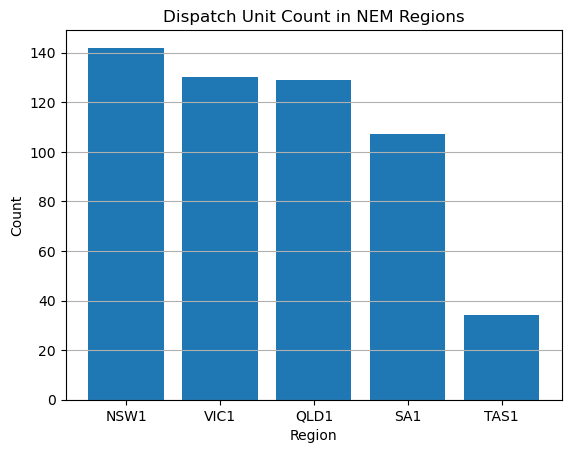

In [8]:
fig, ax = plt.subplots()

categoricalBarPlot(ax, dispatch_units, "Region")
plt.title("Dispatch Unit Count in NEM Regions")
plt.show()

New South Wales has the most dispatch units, followed by Victoria, Queensland, South Australia, then Tasmania. 

### Dispatch Type

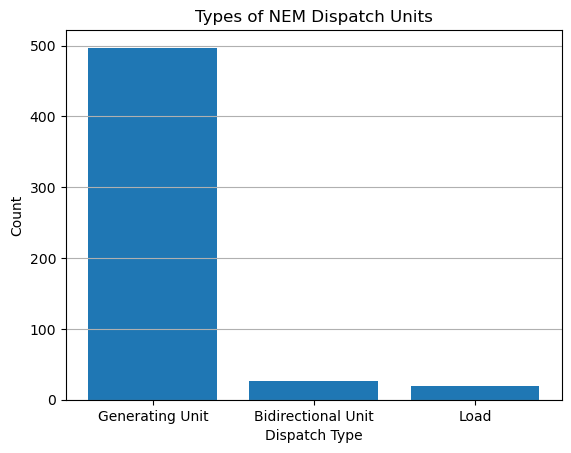

In [9]:
fig, ax = plt.subplots()

categoricalBarPlot(ax, dispatch_units, "Dispatch Type")
plt.title("Types of NEM Dispatch Units")
plt.show()

The vast majority of dispatch units in the table are generating units, with only a few bidirectional units and loads registered here.

### Market Participation

In [10]:
print("Categories:", set(dispatch_units["Category"]))

Categories: {'market', 'Non-Market', 'Market'}


Clearly the presence of both `market` and `Market` in `Category` is an error.

In [11]:
dispatch_units.loc[dispatch_units["Category"] == "market", "Category"] = "Market"

print("Categories:", set(dispatch_units["Category"]))

Categories: {'Non-Market', 'Market'}


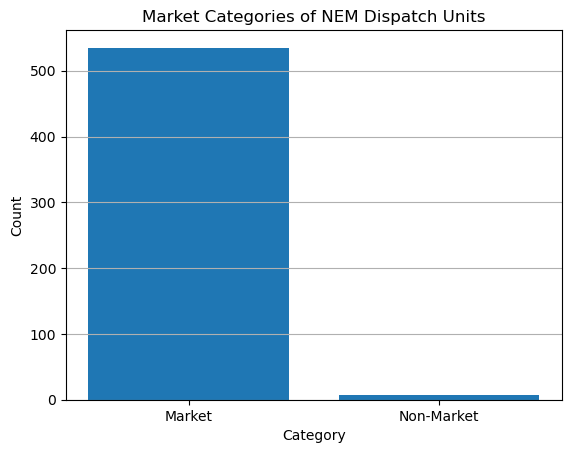

In [12]:
fig, ax = plt.subplots()

categoricalBarPlot(ax, dispatch_units, "Category")
plt.title("Market Categories of NEM Dispatch Units")
plt.show()

The vast majority of dispatch units are market participants.

### Scheduling

In [13]:
print("Classifications:", set(dispatch_units["Classification"]))

Classifications: {'Scheduled*', 'Non-Scheduled*', 'Non-Scheduled', 'Scheduled', 'Non-Scheduled**', 'Semi-Scheduled'}


The meanings of `Scheduled*`, `Non-Scheduled*`, and `Non-Scheduled**` are explained in the full [NEM Registration and Exemption List](https://wa.aemo.com.au/-/media/files/electricity/nem/participant_information/nem-registration-and-exemption-list.xlsx?la=en): 

***Scheduled\*** - Participants with this classification are not classified as scheduled load in the National Electricity Market.  However, it is a condition of the registration that they comply with some of the obligations of a market customer in respect of a scheduled load.  These units are dispatched as if they were scheduled loads with respect to thier dispatch bids, targets and consumption.  Accordingly, information about these dispatchable units are reported as market scheduled load information.*

***Non-Scheduled\***  - Participants with this classification are market non-scheduled generating units.  However, it is a condition of the registration of these units that the Registered Participant complies with some of the obligations of a Semi-Scheduled Generator.  These units are dispatched as semi-scheduled generating units with respect to their dispatch offers, dispatch levels and generation outputs.  Accordingly, information about these dispatchable units are reported as semi-scheduled generating unit information.*

***Non-Scheduled\*\*** - Participants with this classification are market non-scheduled generating units. However, it is a condition of the registration of these units that the Registered Participant complies with some of the obligations of a Scheduled Generator. These unit are dispatched as scheduled generating units with respect to their dispatch offers, targets and generation outputs. Accordingly, information about these dispatchable units are reported as scheduled generating unit information.*

In particular, we glean from the descriptions that when interpreting the data associated to these dispatch units: 
- units marked `Scheduled*` should be treated as `Scheduled`, 
- units marked `Non-Scheduled*` should be treated as `Semi-Scheduled`, and 
- units marked `Non-Scheduled**` should be treated as `Scheduled`.

We apply these transformations to produce a column `Classification (adjusted)`.

In [14]:
classification_map = {"Scheduled": "Scheduled", 
                      "Scheduled*": "Scheduled", 
                      "Non-Scheduled**": "Scheduled",
                      "Semi-Scheduled": "Semi-Scheduled",
                      "Non-Scheduled*": "Semi-Scheduled",
                      "Non-Scheduled": "Non-Scheduled"}

dispatch_units["Classification (adjusted)"] = dispatch_units["Classification"].apply(lambda x : classification_map[x])

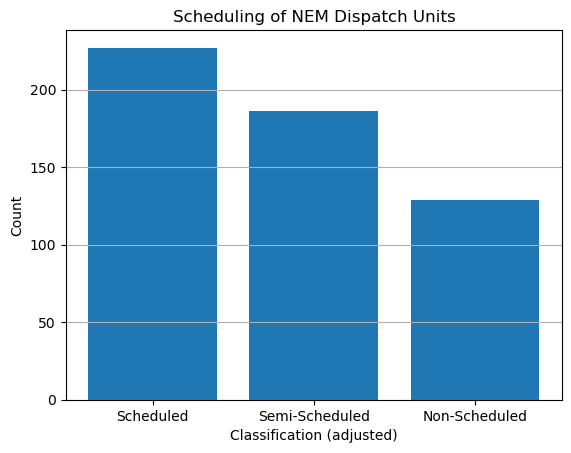

In [15]:
fig, ax = plt.subplots()

categoricalBarPlot(ax, dispatch_units, "Classification (adjusted)")
plt.title("Scheduling of NEM Dispatch Units")
plt.show()

Most dispatch units are scheduled, so participate in central dispatch. The next largest classification is semi-scheduled, which consists of dispatch units that are only required to participate in central dispatch at certain times (mainly wind and solar units, whose output is weather-dependent). The smallest category in this classification is the non-scheduled category, consisting of units that do not participate in central dispatch.

### Fuel Sources
We check the possible values of `(Fuel Source - Primary, Fuel Source - Descriptor)` pairs below:

In [16]:
dispatch_units[["Fuel Source - Primary", "Fuel Source - Descriptor"]] \
    .drop_duplicates() \
    .sort_values(by=["Fuel Source - Primary", "Fuel Source - Descriptor"])

,Fuel Source - Primary,Fuel Source - Descriptor
26,-,-
0,Battery storage,Grid
222,Battery storage,Wind
29,Fossil,Black Coal
282,Fossil,Brown Coal
57,Fossil,Coal Seam Methane
7,Fossil,Diesel
211,Fossil,Ethane
328,Fossil,Kerosene
11,Fossil,Natural Gas


Here we see an error in the table: both `Solar` and `solar` appear in `Fuel Source - Descriptor`. We fix this below:

In [17]:
dispatch_units.loc[dispatch_units["Fuel Source - Descriptor"] == "solar", "Fuel Source - Descriptor"] = "Solar"

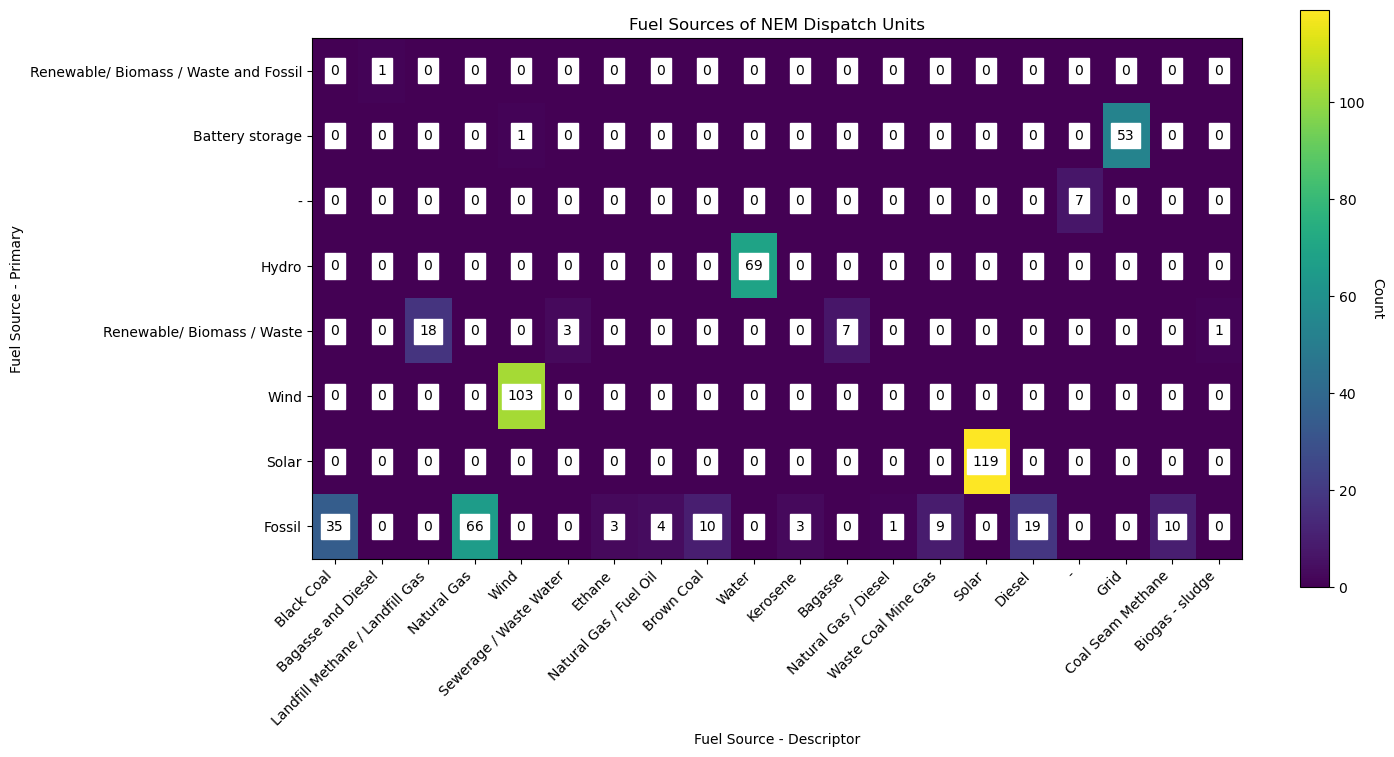

In [18]:
fig, ax = plt.subplots(figsize = (15,7.5))

heatMap(ax, dispatch_units, "Fuel Source - Descriptor", "Fuel Source - Primary", 1.4)
plt.xticks(rotation=45, ha='right')
plt.title("Fuel Sources of NEM Dispatch Units")
plt.show()

The above table gives a thorough breakdown of the fuel sources of dispatch units. We see most primary fuel categories only have one or two descriptor subcategories, however fossil fuels are broken down into many different types. The most common type of fossil fuel plant is natural gas, followed by black coal, diesel, then other sources.

For later use, we will group the fuel sources into broad categories:

In [19]:
def categorise_broadly(fuel_primary, fuel_descriptor):
    if fuel_primary in {"-", 
                        "Battery storage", 
                        "Hydro", 
                        "Wind"}:
        return fuel_primary
    if fuel_primary == "Solar":
        return "Solar (plant)"
    if "Bio" in fuel_primary:
        return "Bio"
    if fuel_descriptor in {"Coal Seam Methane", 
                           "Ethane", 
                           "Natural Gas", 
                           "Natural Gas / Diesel", 
                           "Natural Gas / Fuel Oil", 
                           "Waste Coal Mine Gas"}:
        return "Gas"
    if fuel_descriptor in {"Diesel", "Kerosene"}:
        return "Liquid fuel"
    
    return "Coal"

dispatch_units["Broad Category"] = \
    dispatch_units.apply(
        lambda x : categorise_broadly(x["Fuel Source - Primary"], x["Fuel Source - Descriptor"]), 
        axis=1)

Here we write `Solar (plant)` to distinguish from `Solar (rooftop)` which will be introduced later.

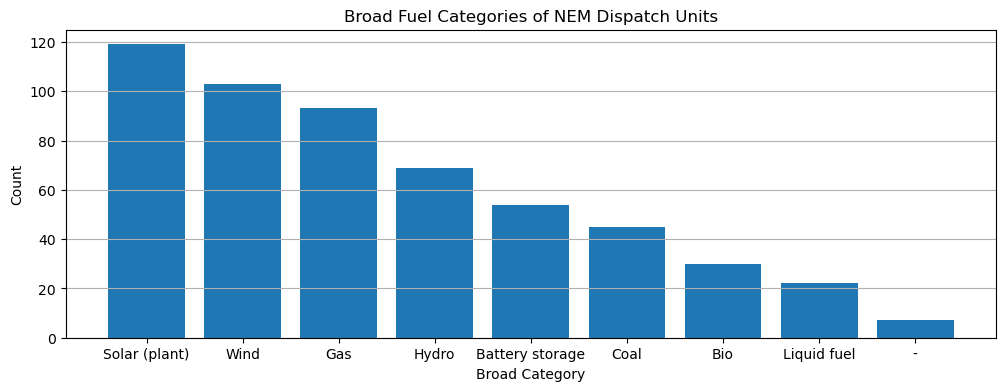

In [20]:
fig, ax = plt.subplots(figsize = (12,4))

categoricalBarPlot(ax, dispatch_units, "Broad Category")
plt.title("Broad Fuel Categories of NEM Dispatch Units")
plt.show()

Here we see the most common broad category of dispatch unit is solar plants, followed by wind, gas, hydro, battery storage, coal, bio, then liquid fuel.

### Technology Types

In [21]:
dispatch_units[["Technology Type - Primary", "Technology Type - Descriptor"]] \
    .drop_duplicates() \
    .sort_values(by=["Technology Type - Primary", "Technology Type - Descriptor"])

,Technology Type - Primary,Technology Type - Descriptor
26,-,-
21,Combustion,Combined Cycle Gas Turbine (CCGT)
7,Combustion,Compression Reciprocating Engine
437,Combustion,Open Cycle Gas Turbine (OCGT)
11,Combustion,Open Cycle Gas turbines (OCGT)
8,Combustion,Spark Ignition Reciprocating Engine
29,Combustion,Steam Sub-Critical
78,Combustion,Steam Super Critical
464,Combustion,Steam Super Critical and Compression Reciproca...
19,Renewable,Hydro - Gravity


Once again there are some capitalisation errors in the data (two instances of open cycle gas turbine and each type of photovoltaic panel), which we correct below.

In [22]:
corrections = {"Open Cycle Gas turbines (OCGT)": "Open Cycle Gas Turbine (OCGT)",
               "Photovoltaic Flat panel": "Photovoltaic Flat Panel",
               "Photovoltaic Tracking Flat panel": "Photovoltaic Tracking Flat Panel"}

for incorrect, correct in corrections.items():
    dispatch_units.loc[dispatch_units["Technology Type - Descriptor"] == incorrect, "Technology Type - Descriptor"] = correct

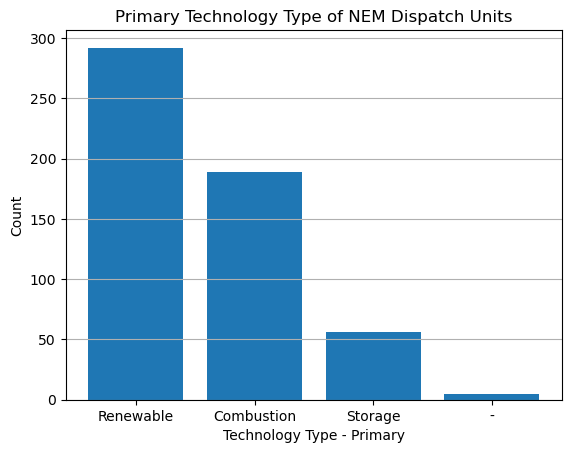

In [23]:
fig, ax = plt.subplots()

categoricalBarPlot(ax, dispatch_units, "Technology Type - Primary")
plt.title("Primary Technology Type of NEM Dispatch Units")
plt.show()

Most dispatch units within NEM regions are classed as renewable, with the next most common category being combustion. Storage is the least common technology type, with just over 50 units out of 542.

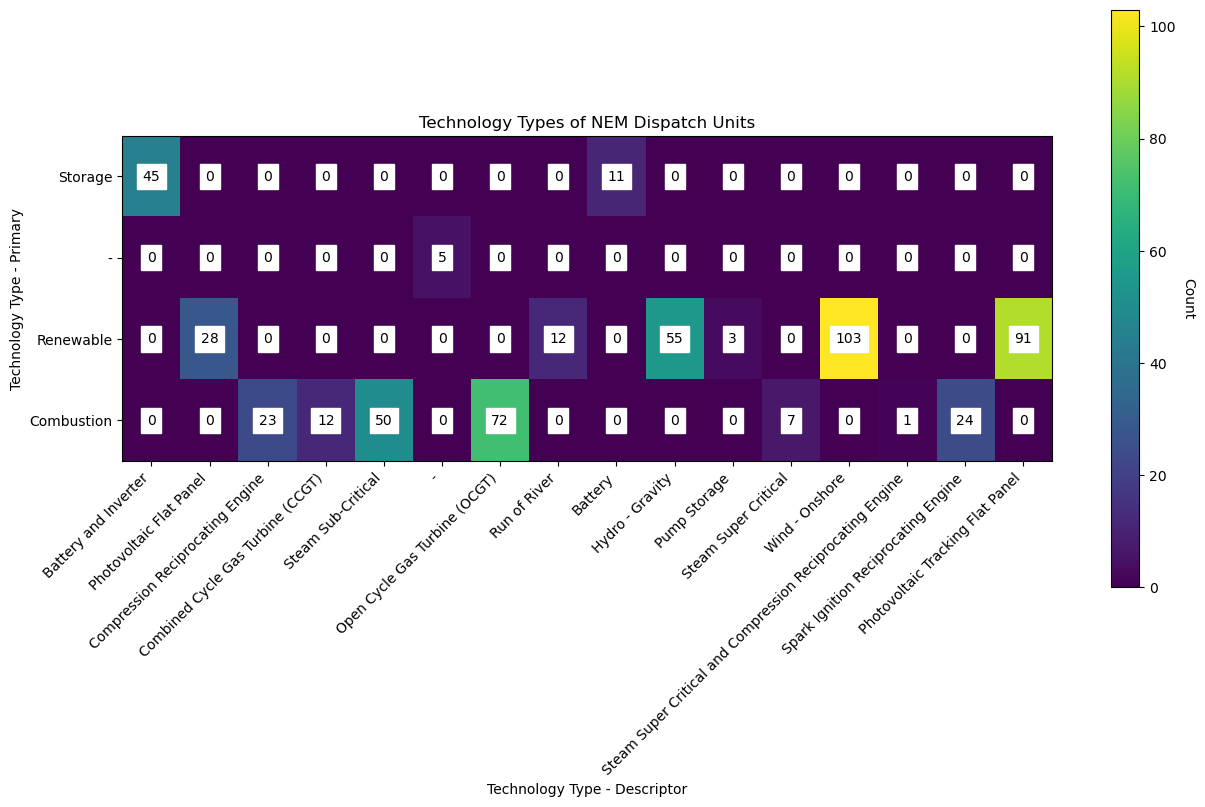

In [24]:
fig, ax = plt.subplots(figsize = (15,7.5))

heatMap(ax, dispatch_units, "Technology Type - Descriptor", "Technology Type - Primary", 1.4)
plt.xticks(rotation=45, ha='right')
plt.title("Technology Types of NEM Dispatch Units")
plt.show()

The above table gives a breakdown of the technology types of dispatch units. In the renewables row, we can see a breakdown of the renewable sources into subcategories. Wind appears as the most common type, however note that solar is broken down into two subcategories depending whether the panels are tracking panels or not. The next table will give a clearer breakdown of renewables into technology types.

### Joint Fuel and Technology Types

In [25]:
dispatch_units[["Fuel Source - Primary", "Technology Type - Primary"]].drop_duplicates()

,Fuel Source - Primary,Technology Type - Primary
0,Battery storage,Storage
2,Hydro,Renewable
3,Solar,Renewable
7,Fossil,Combustion
9,Wind,Renewable
26,-,-
47,Renewable/ Biomass / Waste,Renewable
63,Renewable/ Biomass / Waste,Combustion
98,-,Storage
464,Renewable/ Biomass / Waste and Fossil,Combustion


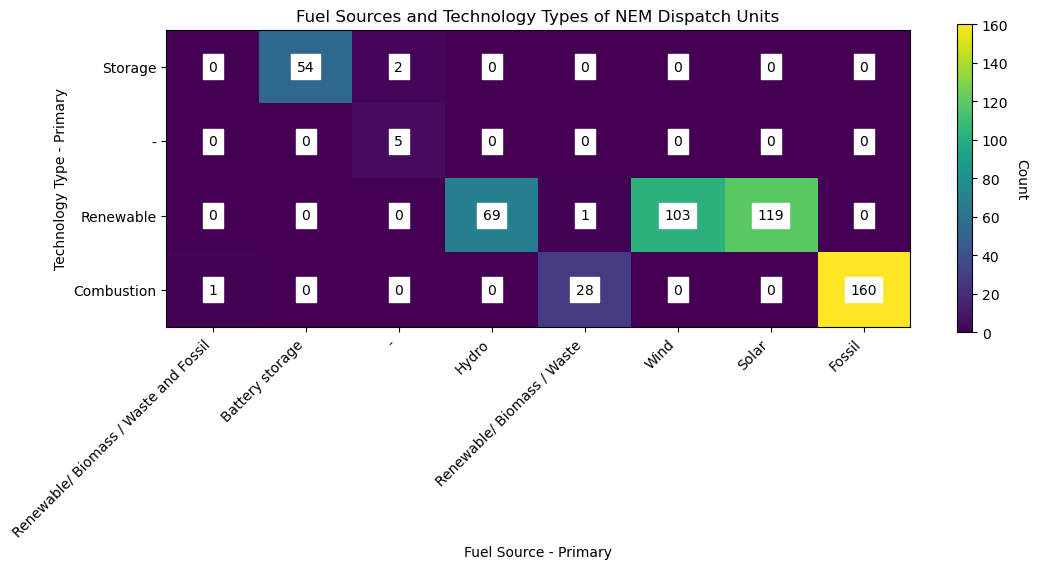

In [26]:
fig, ax = plt.subplots(figsize=(12,4))

heatMap(ax, dispatch_units, "Fuel Source - Primary", "Technology Type - Primary", 0.8)
plt.title("Fuel Sources and Technology Types of NEM Dispatch Units")
plt.xticks(rotation=45, ha='right')
plt.show()

From the above table, we can more clearly see the breakdown of renewables. Solar is the most common, followed by wind, then hydro. Note there is also a single "Renewable / Biomass / Waste" unit classed as renewable.

### Missing Values

By now, we have seen a few instances of values in the table listed as `-`. We check these missing values here.

In [27]:
dispatch_units = dispatch_units.replace("-", np.nan)

In [28]:
dispatch_units[dispatch_units.isna().any(axis=1)]

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID,Classification (adjusted),Broad Category
26,Basslink Pty Ltd,Basslink HVDC Link,TAS1,Generating Unit,Market,Non-Scheduled,NaN,NaN,NaN,NaN,N,BLNKTAS,Non-Scheduled,NaN
27,Basslink Pty Ltd,Basslink HVDC Link,VIC1,Generating Unit,Market,Non-Scheduled,NaN,NaN,NaN,NaN,N,BLNKVIC,Non-Scheduled,NaN
80,CS Energy Limited,Callide Power Station,QLD1,Generating Unit,Market,Non-Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,N,NaN,Non-Scheduled,Coal
98,South Australian Water Corporation,Christies Beach Wastewater Treatment Plant,SA1,Load,Market,Scheduled,NaN,NaN,Storage,Battery and Inverter,Y,CBWWBA1L,Scheduled,NaN
223,Hornsdale Power Reserve Pty Ltd,Hornsdale Power Reserve,SA1,Load,Market,Scheduled,NaN,NaN,Storage,Battery,N,HPRL1,Scheduled,NaN
401,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Load,Market,Scheduled,NaN,NaN,NaN,NaN,Y,SHPUMP,Scheduled,NaN
464,Tully Sugar Limited,Tully Sugar Mill,QLD1,Generating Unit,Non-Market,Non-Scheduled,Renewable/ Biomass / Waste and Fossil,Bagasse and Diesel,Combustion,Steam Super Critical and Compression Reciproca...,NaN,TULLYSM1,Non-Scheduled,Bio
522,CleanCo Queensland Limited,Wivenhoe Power Station,QLD1,Load,Market,Scheduled,NaN,NaN,NaN,NaN,Y,PUMP1,Scheduled,NaN
523,CleanCo Queensland Limited,Wivenhoe Power Station,QLD1,Load,Market,Scheduled,NaN,NaN,NaN,NaN,Y,PUMP2,Scheduled,NaN


In later analysis we will be quantifying the amount of energy generation in NEM regions. In particular, we will not consider loads, or interconnectors. Thankfully, most entries with missing values here are loads or interconnectors. The only exceptions are Callide Power Station (DUID missing) and Tully Sugar Mill (Aggregation missing). We will leave these entries as they are.

# 3. Energy Generation Data

At the beginning of each dispatch interval, AEMO records the instantaneous power reading from most dispatch units through a system known as SCADA. In this section, we take a look at SCADA readings from AEMO, with a focus on energy readings from generating units. These readings do not include rooftop PV generation, so we import rooftop PV data separately. We break down the contributions of each fuel source to energy in the electricity grid on the date 2024/11/01.

## 3.1 Dispatch Unit SCADA Readings

The SCADA readings for each dispatch unit (for which SCADA is available) over each 5-minute interval are collected in the table `DISPATCH_UNIT_SCADA`. In this section we import the dispatch data over a one-day period.

### Import SCADA readings

In [29]:
start_time = '2024/11/01 00:00:00'
end_time = '2024/11/02 00:00:00'

scada_readings = dynamic_data_compiler(
    start_time, end_time, 'DISPATCH_UNIT_SCADA', raw_data_cache
)

INFO: Compiling data for table DISPATCH_UNIT_SCADA
INFO: Returning DISPATCH_UNIT_SCADA.


In [30]:
scada_readings.head()

,SETTLEMENTDATE,DUID,SCADAVALUE
0,2024-11-01 00:05:00,ADPBA1,-0.006
1,2024-11-01 00:05:00,ADPPV1,0.000
2,2024-11-01 00:05:00,AGLHAL,0.000
3,2024-11-01 00:05:00,AGLSOM,0.000
4,2024-11-01 00:05:00,ANGAST1,0.000


### Add Dispatch Unit Info to SCADA Table

In [31]:
scada_readings_with_DU_info = scada_readings.merge(dispatch_units, on="DUID", how="left")

In [32]:
scada_readings_with_DU_info.head()

,SETTLEMENTDATE,DUID,SCADAVALUE,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,Classification (adjusted),Broad Category
0,2024-11-01 00:05:00,ADPBA1,-0.006,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,Scheduled,Battery storage
1,2024-11-01 00:05:00,ADPPV1,0.000,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat Panel,Y,Semi-Scheduled,Solar (plant)
2,2024-11-01 00:05:00,AGLHAL,0.000,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas / Diesel,Combustion,Open Cycle Gas Turbine (OCGT),Y,Scheduled,Gas
3,2024-11-01 00:05:00,AGLSOM,0.000,AGL Hydro Partnership,Somerton Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas Turbine (OCGT),Y,Scheduled,Gas
4,2024-11-01 00:05:00,ANGAST1,0.000,Snowy Hydro Limited,Angaston Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Diesel,Combustion,Compression Reciprocating Engine,Y,Scheduled,Liquid fuel


## 3.2 Rooftop PV Data

The data for rooftop PV readings are contained in `ROOFTOP_PV_ACTUAL`. Here we import rooftop PV data for the date 2024/11/01, and prepare it for analysis.

In [33]:
rooftop_pv = dynamic_data_compiler(
    start_time, end_time, 'ROOFTOP_PV_ACTUAL', raw_data_cache
)

INFO: Compiling data for table ROOFTOP_PV_ACTUAL
INFO: Returning ROOFTOP_PV_ACTUAL.


In [34]:
rooftop_pv.head()

,INTERVAL_DATETIME,REGIONID,POWER,LASTCHANGED,TYPE,QI
0,2024-11-01 00:30:00,NSW1,0.0,2024-11-01 00:49:19,MEASUREMENT,1.0
1,2024-11-01 00:30:00,QLD1,0.0,2024-11-01 00:49:19,MEASUREMENT,1.0
2,2024-11-01 00:30:00,QLDC,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0
3,2024-11-01 00:30:00,QLDN,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0
4,2024-11-01 00:30:00,QLDS,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0


### Remove Superfluous Regions and Satellite Data

In [35]:
print("Regions:".ljust(8), set(rooftop_pv["REGIONID"]))
print("Types:".ljust(8), set(rooftop_pv["TYPE"]))

Regions: {'QLD1', 'TASS', 'VIC1', 'QLDN', 'QLDS', 'TAS1', 'QLDC', 'TASN', 'NSW1', 'SA1'}
Types:   {'MEASUREMENT', 'SATELLITE'}


The rooftop data contains certain redundant information. In particular, the entry `QLD1` is the sum of the entries `QLDC`, `QLDN`, `QLDS` at any time, as `TAS1` is the sum of `TASN` and `TASS`. Furthermore there are two types of data available: `MEASUREMENT` and `SATELLITE`. We will use the measurements for our analysis.

In [36]:
valid_regions = {'NSW1', 'QLD1', 'SA1', 'TAS1', 'VIC1'}

rooftop_pv = rooftop_pv.loc[(rooftop_pv["REGIONID"].isin(valid_regions)) & (rooftop_pv["TYPE"] == "MEASUREMENT")]

In [37]:
rooftop_pv.head()

,INTERVAL_DATETIME,REGIONID,POWER,LASTCHANGED,TYPE,QI
0,2024-11-01 00:30:00,NSW1,0.0,2024-11-01 00:49:19,MEASUREMENT,1.0
1,2024-11-01 00:30:00,QLD1,0.0,2024-11-01 00:49:19,MEASUREMENT,1.0
5,2024-11-01 00:30:00,SA1,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0
6,2024-11-01 00:30:00,TAS1,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0
9,2024-11-01 00:30:00,VIC1,0.0,2024-11-01 00:49:20,MEASUREMENT,1.0


### Upscale Rooftop PV Data to 5-minute Intervals

To combine this with the 5-minute SCADA readings data, we must either downsample the 5-minute readings, or upsample the 30-minute readings. We choose to upsample the 30-minute readings, by interpolating linearly between data points. We first split the data into separate regions to make the interpolation easier.

In [38]:
rooftop_pv_by_region = {region: rooftop_pv.loc[rooftop_pv["REGIONID"] == region, ["INTERVAL_DATETIME", "POWER"]] 
                        for region in set(rooftop_pv["REGIONID"])}

In [39]:
# Set the index to be INTERVAL_DATETIME, and convert from data frames to series
for region, data_frame in rooftop_pv_by_region.items():
    data_frame.set_index("INTERVAL_DATETIME", inplace=True)
    rooftop_pv_by_region[region] = data_frame["POWER"]

We add an extra data point at 00:05:00 to match with the scada reading data, and linearly interpolate between readings at 5-minute intervals.

In [40]:
for region, region_series in rooftop_pv_by_region.items():
    # Add timepoint at 00:05:00
    region_series["2024-11-01 00:05:00"] = 0.0
    # Upsample to 5-minute intervals and interpolate linearly
    rooftop_pv_by_region[region] = region_series.resample("5min").asfreq()
    rooftop_pv_by_region[region].sort_index(inplace=True)
    rooftop_pv_by_region[region].interpolate(inplace=True)
    # Convert the series back to data frames that include REGIONID
    rooftop_pv_by_region[region] = rooftop_pv_by_region[region].to_frame()
    rooftop_pv_by_region[region]["REGIONID"] = region
    rooftop_pv_by_region[region].reset_index(inplace=True)

We now recombine the data from multiple regions into a single dataframe.

In [41]:
rooftop_pv_upsampled = pd.concat([region_frame for region, region_frame in rooftop_pv_by_region.items()], axis=0)

In [42]:
rooftop_pv_upsampled.sort_values("INTERVAL_DATETIME", inplace=True)

rooftop_pv_upsampled.head()

,INTERVAL_DATETIME,POWER,REGIONID
0,2024-11-01 00:05:00,0.0,QLD1
0,2024-11-01 00:05:00,0.0,NSW1
0,2024-11-01 00:05:00,0.0,VIC1
0,2024-11-01 00:05:00,0.0,SA1
0,2024-11-01 00:05:00,0.0,TAS1


## 3.3 Combined SCADA and Rooftop PV Data Analysis

We combine the rooftop PV data and SCADA readings into a single dataframe, adding some extra information to the rooftop PV rows for analysis later.

In [43]:
# Add information on rooftop solar generation for analysis
rooftop_pv_upsampled["Broad Category"] = "Solar (rooftop)"
rooftop_pv_upsampled["Dispatch Type"] = "Generating Unit"
rooftop_pv_upsampled["Technology Type - Primary"] = "Renewable"

# Rename columns in scada readings table to match columns in rooftop PV table
scada_readings_with_DU_info.rename(columns={"SETTLEMENTDATE": "INTERVAL_DATETIME", "SCADAVALUE": "POWER", "Region": "REGIONID"}, inplace=True)

In [44]:
full_readings = pd.concat([scada_readings_with_DU_info, rooftop_pv_upsampled], axis=0)

### Percentage Renewable Generation

We check the total percentage of renewable generation on 2024/11/01, as well as how this percentage evolves throughout the day.

In [45]:
renewable_gen_total = full_readings.loc[
    (full_readings["Technology Type - Primary"] == "Renewable") & (full_readings["Dispatch Type"] == "Generating Unit"), 
    "POWER"
    ].sum()
all_gen_total = full_readings.loc[(full_readings["Dispatch Type"] == "Generating Unit"), "POWER"].sum()

print("Total percentage of renewable generation:", np.round(100 * renewable_gen_total / all_gen_total, 2), "%")

Total percentage of renewable generation: 46.4 %


The total percentage of renewable energy generation as per AEMO SCADA readings and PV generation measurements on 2024/11/01 was 46.4%.

We plot how the percentage of renewable energy generation changes throughout the 24-hour period.

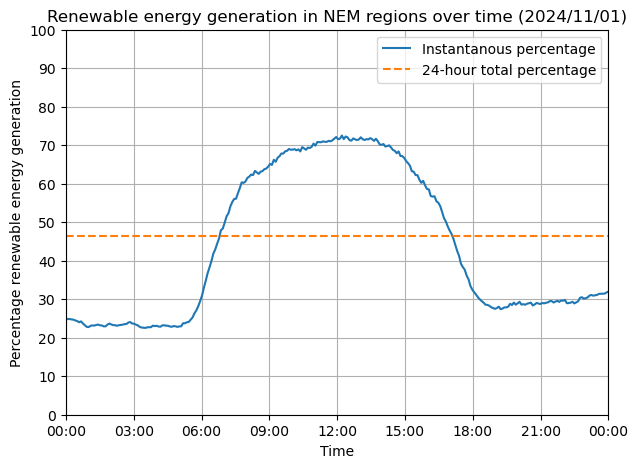

In [46]:
all_generators = full_readings.loc[full_readings["Dispatch Type"] == "Generating Unit"]
renewable_generators = all_generators.loc[all_generators["Technology Type - Primary"] == "Renewable"]

all_energy = all_generators.groupby("INTERVAL_DATETIME").sum()["POWER"]
renewable_energy = renewable_generators.groupby("INTERVAL_DATETIME").sum()["POWER"]

renewable_percentage = 100 * (renewable_energy / all_energy)


plt.figure(figsize=(7,5))
plt.plot(np.linspace(0, 24, renewable_percentage.shape[0]), renewable_percentage)
plt.title("Renewable energy generation in NEM regions over time (2024/11/01)")
plt.grid()
plt.xticks(np.linspace(0, 24, 9), labels=["00:00", "03:00", "06:00", "09:00", "12:00", "15:00", "18:00", "21:00", "00:00"])
plt.xlabel("Time")
plt.yticks(np.linspace(0, 100, 11))
ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xlim([0,24])
plt.ylabel("Percentage renewable energy generation")
plt.plot([0, 24], [46.4, 46.4], '--')
plt.legend(["Instantanous percentage", "24-hour total percentage"])
plt.show()

In [47]:
renewable_percentage.describe()[['min', 'max']]

min    22.543529
max    72.515121
Name: POWER, dtype: float64

We see that during daylight hours the proportion of renewables rises greatly due to solar generation, reaching a maximum of 72.5%. The lowest percentage was observed overnight, with a minimum of 22.5% renewable energy generation.

### Energy Generation by Category

In [48]:
set(full_readings.loc[full_readings["Dispatch Type"] == "Generating Unit", "Broad Category"])

{'Battery storage',
 'Bio',
 'Coal',
 'Gas',
 'Hydro',
 'Liquid fuel',
 'Solar (plant)',
 'Solar (rooftop)',
 'Wind'}

In [49]:
generator_categories = ["Coal", "Gas", "Liquid fuel", "Bio", "Hydro", "Wind", "Solar (plant)", "Solar (rooftop)"]

power_by_category = pd.DataFrame()

for category in generator_categories:
    power_by_category[category] = full_readings.loc[
        (full_readings["Broad Category"] == category) & (full_readings["Dispatch Type"] == "Generating Unit")
        ].groupby("INTERVAL_DATETIME").sum()["POWER"]

In [50]:
power_by_category.head()

,Coal,Gas,Liquid fuel,Bio,Hydro,Wind,Solar (plant),Solar (rooftop)
INTERVAL_DATETIME,,,,,,,,
2024-11-01 00:05:00,14500.99996,367.104170,0.0,33.427840,1792.512016,3085.827540,-0.106944,0.0
2024-11-01 00:10:00,14436.70078,370.656180,0.0,33.579842,1836.195036,3079.936624,-0.106944,0.0
2024-11-01 00:15:00,14424.23044,377.048801,0.0,34.438841,1882.201033,3024.968684,-0.036084,0.0
2024-11-01 00:20:00,14378.33397,364.161170,0.0,34.609843,1862.438478,2998.224386,-0.036084,0.0
2024-11-01 00:25:00,14291.33815,365.558270,0.0,35.048840,1856.893117,2958.337175,-0.036084,0.0


In [51]:
power_by_category["Liquid fuel"].describe()[['min', 'max']]

min    0.0
max    0.0
Name: Liquid fuel, dtype: float64

We see from the above cell that there is zero liquid fuel generation recorded by SCADA on the date 2024/11/01 within NEM regions. We will thus drop this column from the summary.

In [52]:
power_by_category.drop(columns=["Liquid fuel"], inplace=True)

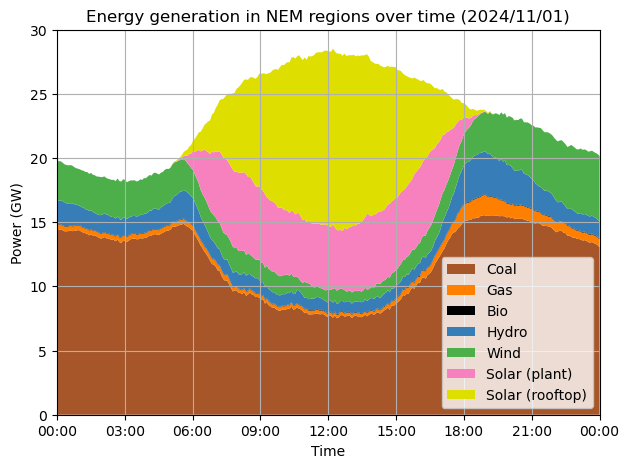

In [53]:
colour_list = ['#a65628',
    '#ff7f00', 
    'black',
    '#377eb8',
    '#4daf4a',
    '#f781bf',
    '#dede00']


plt.figure(figsize=(7,5))
plt.stackplot(np.linspace(0, 24, power_by_category.shape[0]), 
              [power_by_category[category].to_numpy() / 1000 for category in power_by_category.columns], 
              labels=power_by_category.columns, 
              colors=colour_list[:len(power_by_category.columns)]
              )
plt.grid()
plt.title("Energy generation in NEM regions over time (2024/11/01)")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_ylim([0,30])
plt.xticks([0,3,6,9,12,15,18,21,24], labels=["00:00", "03:00", "06:00", "09:00", "12:00", "15:00", "18:00", "21:00", "00:00"])
plt.xlabel("Time")
plt.ylabel("Power (GW)")
plt.legend()
plt.show()

Observations:
- Rooftop solar generation fulfills much of the demand for electricity during daylight hours, to the extent that a large dip is observed in coal-powered generation.
- The amount of wind generation varies significantly over the 24 hour period.
- Generation due to bio-energy is barely visible on the graph.

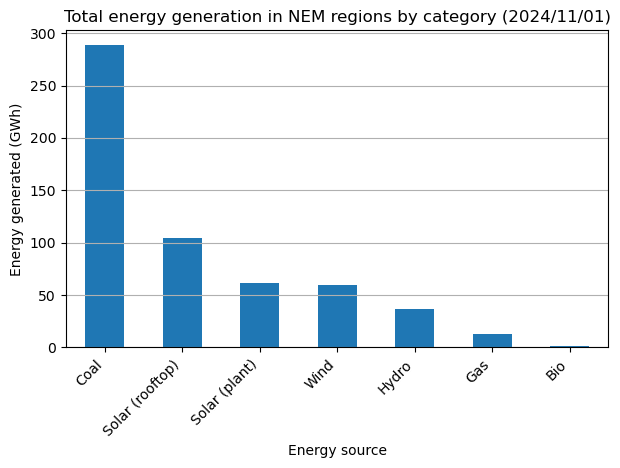

In [54]:
# Here we divide by 1000 to convert MW to GW, and 12 to convert 5-minutes to 1-hour
plt.figure(figsize=(7,5))
(pd.melt(power_by_category).groupby('variable')['value'].sum()/(1000*12)).sort_values(ascending=False).plot(kind='bar', figsize=(7,4.12))
plt.title("Total energy generation in NEM regions by category (2024/11/01)")
ax = plt.gca()
ax.yaxis.grid()
plt.ylabel("Energy generated (GWh)")
plt.xlabel("Energy source")
plt.xticks(rotation=45, ha='right')
plt.show()

Coal generated the most energy over the 24-hour period, followed by solar (rooftop then plant), wind, hydro, gas and finally bio.

# 4. CO2-e Emissions

In this section, we take a look at greenhouse gas emissions due to electricity generation in NEM participant regions on 2024/11/01. The emissions data for dispatch units is not accessible through NEMOSIS, but can be downloaded [directly from nemweb](http://nemweb.com.au/Reports/Current/CDEII/CO2EII_AVAILABLE_GENERATORS.CSV).

In [55]:
cdeii = pd.read_csv("http://nemweb.com.au/Reports/Current/CDEII/CO2EII_AVAILABLE_GENERATORS.CSV", header=1)

In [56]:
cdeii.head()

,I,CO2EII,PUBLISHING,1,STATIONNAME,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,D,CO2EII,PUBLISHING,1.0,Appin Power Plant,APPIN,APPIN,NSW1,0.56318,Coal seam methane,NGA 2024
1,D,CO2EII,PUBLISHING,1.0,Avonlie Solar Farm,AVLSF1,AVLSF1,NSW1,0.00000,Solar,ISP2024
2,D,CO2EII,PUBLISHING,1.0,Bango 973 Wind Farm,BANGOWF1,BANGOWF1,NSW1,0.00000,Wind,ISP2024
3,D,CO2EII,PUBLISHING,1.0,Bango 999 Wind Farm,BANGOWF2,BANGOWF2,NSW1,0.00000,Wind,ISP2024
4,D,CO2EII,PUBLISHING,1.0,Burrendong Hydro Power Station,BDONGHYD,BDONGHYD,NSW1,0.00000,Hydro,ISP2024


The important information here is the `CO2E_EMISSIONS_FACTOR`. Referring to the table on page 4 of AEMO's [Carbon Dioxide Equivalent Intensity Index Procedures](https://aemo.com.au/-/media/files/stakeholder_consultation/consultations/nem-consultations/2019/cdeii/carbon-dioxide-equivalent-intensity-index-procedure-v40final.pdf?la=en&hash=6A6E4BFDECC6A1959720311978CEE18F), the units for this column are t CO2-e/MWh. Here t CO2-e denotes *tonnes of carbon-dioxide equivalent*: for any greenhouse gas (not necessarily CO2), 1 t CO2-e denotes the amount of emissions of that particular greenhouse gas required to have the same global warming impact as one tonne of CO2 emissions. Thus, CO2-e gives a uniform standard by which to measure the impacts of distinct greenhouse gases.

To compute the equivalent carbon emissions, we join this table to the dispatch data table.

In [57]:
co2e_data = cdeii[["DUID", "CO2E_EMISSIONS_FACTOR"]]

co2e_data.head()

,DUID,CO2E_EMISSIONS_FACTOR
0,APPIN,0.56318
1,AVLSF1,0.00000
2,BANGOWF1,0.00000
3,BANGOWF2,0.00000
4,BDONGHYD,0.00000


In [58]:
full_readings = full_readings.merge(co2e_data, on="DUID", how="left")

full_readings.head()

,INTERVAL_DATETIME,DUID,POWER,Participant,Station Name,REGIONID,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,Classification (adjusted),Broad Category,CO2E_EMISSIONS_FACTOR
0,2024-11-01 00:05:00,ADPBA1,-0.006,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,Scheduled,Battery storage,0.000000
1,2024-11-01 00:05:00,ADPPV1,0.000,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat Panel,Y,Semi-Scheduled,Solar (plant),0.000000
2,2024-11-01 00:05:00,AGLHAL,0.000,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas / Diesel,Combustion,Open Cycle Gas Turbine (OCGT),Y,Scheduled,Gas,0.642656
3,2024-11-01 00:05:00,AGLSOM,0.000,AGL Hydro Partnership,Somerton Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas Turbine (OCGT),Y,Scheduled,Gas,0.732595
4,2024-11-01 00:05:00,ANGAST1,0.000,Snowy Hydro Limited,Angaston Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Diesel,Combustion,Compression Reciprocating Engine,Y,Scheduled,Liquid fuel,0.685758


The dispatch intervals are 5-minutes long, and power is recorded in MWh. So, to compute the approximate CO2-e emissions over each 5-minute interval, we multiply by the CO2-e emissions factor for each dispatch unit and divide by 12 (=60minutes/5minutes).

In [59]:
full_readings["CO2e Emissions"] = full_readings["POWER"] * full_readings["CO2E_EMISSIONS_FACTOR"] / 12

### Total CO2-e Emissions

In [60]:
# Multiply by 12 to convert rate from per-5-min to per-hour
min_emissions_rate = full_readings.groupby("INTERVAL_DATETIME")["CO2e Emissions"].sum().describe()["min"] * 12
max_emissions_rate = full_readings.groupby("INTERVAL_DATETIME")["CO2e Emissions"].sum().describe()["max"] * 12

print("Minimum emissions rate:", min_emissions_rate, "t CO2-e / h")
print("Maximum emissions rate:", max_emissions_rate, "t CO2-e / h")

Minimum emissions rate: 7350.331653043577 t CO2-e / h
Maximum emissions rate: 16350.73916794471 t CO2-e / h


The maximum rate of CO2-e emissions over the 24-hour period is 16,351 t CO2-e / h, and the minimum rate is 7,350 t CO2-e / h.

In [61]:
print("Total CO2-e emissions on 2024/11/01:", np.round(full_readings["CO2e Emissions"].sum(), 2), "t CO2-e")

Total CO2-e emissions on 2024/11/01: 288956.32 t CO2-e


The total CO2-e emissions for the date 2024/11/01 are approximately 289,000 tonnes.

### CO2 Emissions by Region

Below we check the total CO2-e emissions from each region:

In [62]:
full_readings.groupby("REGIONID")["CO2e Emissions"].sum().sort_values(ascending=False)

REGIONID
QLD1    101109.191551
NSW1     94533.687876
VIC1     89028.803126
SA1       4252.615769
TAS1         0.000000
Name: CO2e Emissions, dtype: float64

These readings are a somewhat unfair representation, given South Australia and Tasmania routinely import electricity from Victoria. Ignoring electricity transfer through interconnectors and going purely from energy generation, Queensland creates the most carbon emissions, followed by New South Wales, Victoria, South Australia and finally Tasmania. 

### CO2-e Emissions over 24 Hours

In [63]:
generator_categories = ["Coal", "Gas", "Liquid fuel", "Bio", "Hydro", "Wind", "Solar (plant)", "Solar (rooftop)"]

co2e_emissions_by_category = pd.DataFrame()

for category in generator_categories:
    co2e_emissions_by_category[category] = full_readings.loc[
        (full_readings["Broad Category"] == category) & (full_readings["Dispatch Type"] == "Generating Unit")
        ].groupby("INTERVAL_DATETIME").sum()["CO2e Emissions"]

In [64]:
co2e_emissions_by_category.describe()

,Coal,Gas,Liquid fuel,Bio,Hydro,Wind,Solar (plant),Solar (rooftop)
count,288.000000,288.000000,288.0,288.000000,288.0,288.0,288.0,288.0
mean,960.963008,42.201707,0.0,0.044653,0.0,0.0,0.0,0.0
std,229.405573,30.876329,0.0,0.010801,0.0,0.0,0.0,0.0
min,601.727939,10.206581,0.0,0.029148,0.0,0.0,0.0,0.0
25%,709.870470,19.808842,0.0,0.033376,0.0,0.0,0.0,0.0
50%,1088.604817,25.450675,0.0,0.050402,0.0,0.0,0.0,0.0
75%,1151.629156,63.227839,0.0,0.055004,0.0,0.0,0.0,0.0
max,1239.726313,123.030638,0.0,0.060760,0.0,0.0,0.0,0.0


There is no CO2-e generation due to liquid fuel, hydro, wind or solar, so we remove these from the table.

In [65]:
co2e_emissions_by_category.drop(columns=["Liquid fuel", "Hydro", "Wind", "Solar (plant)", "Solar (rooftop)"], inplace=True)

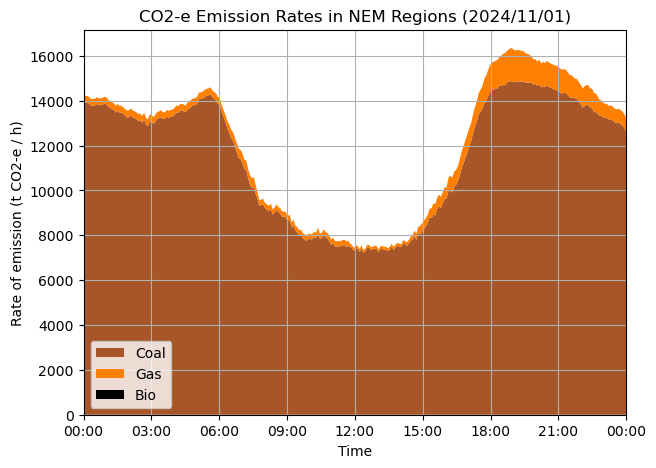

In [66]:
plt.figure(figsize=(7,5))
plt.stackplot(np.linspace(0, 24, co2e_emissions_by_category.shape[0]), 
              [co2e_emissions_by_category[category].to_numpy() * 12 for category in co2e_emissions_by_category.columns], 
              labels=co2e_emissions_by_category.columns, 
              colors=['#a65628','#ff7f00', "black" ]
              )

plt.grid()
plt.title("CO2-e Emission Rates in NEM Regions (2024/11/01)")
ax = plt.gca()
ax.set_xlim([0,24])
plt.xticks([0,3,6,9,12,15,18,21,24], labels=["00:00", "03:00", "06:00", "09:00", "12:00", "15:00", "18:00", "21:00", "00:00"])
plt.xlabel("Time")
plt.ylabel("Rate of emission (t CO2-e / h)")
plt.legend()
plt.show()

Observations:
- Peak CO2-e emissions occur during the evening, reaching a maximum of 16,351 t CO2-e / h at around 19:00.
- Minimum CO2-e emissions occur early afternoon, reaching a minimum of 7,350 t CO2-e / h, which is less than half of the maximum.
- There is a large drop in emissions throughout the day due to solar generation. 
- Emissions due to bio-energy are small to the extent that they cannot be observed on the graph.

# 5. Summary

We analysed electricity generation data from 2024/11/01 provided by AEMO, with a focus on the spread of energy generation among fuel sources, the contribution of renewables to the grid, and the emissions produced by fossil fuels. We found the following:
- Renewable energy generation peaked during daylight hours due to solar generation, but fell overnight.
- Peak renewable generation was approximately 72.5% during daylight hours.
- Minimum renewable generation was roughly 22.5% before sunrise. 
- The total percentage of renewable energy generation over the 24-hour period was approximately 46.4%.
- Total greenhouse gas emissions over the 24-hour period were approximately 298,000 tonnes of CO2-e. 
- Emissions decreased during daylight hours due to solar generation, but rose overnight due to the greater presence of fossil fuels. 
- Peak emissions occured at around 19:00, reaching a maximum rate of 16,351 t CO2-e / h. 
- Minimum emissions occured early afternoon, at a rate of 7,350 t CO2-e / h.
